# **ML Modelling and Interpretation**

## Objectives

1. Perform hyperparameter selection
2. Obtain labels with DBSCAN on sample
3. Train and predict labels on entire dataset with k-NN
4. Interpret results
5. Extract cluster insights

## Inputs

- dbscan_input.csv file, for model training
- acled_clean.csv file, for insights extraction

## Outputs

1. Dataframe with DBSCAN-derived 'cluster' column with labels
2. Set of conflict cluster insights

## Additional Comments

<ins>Why DBSCAN?</ins>

DBSCAN is a density-based clustering algorithm that groups data points that are closely packed together and marks outliers as noise based on their density in the feature space.

Whilst K-Means and hierarchical clustering assume that clusters are compact and spherical, DBSCAN is better at handling real-life irregularities, such as:
- Clusters shaped arbitrarily, no need for perfectly circular or convex shapes
- Noise and outliers, it can identify noise/outliers and treat them separately, rather than squeezing them into the clusters

Given the ACLED dataset and the project's goal, here are some specific advantages:
1. Conflict events vary in shape and size, a one-size-fits-all won't work here
2. DBSCAN can automatically detect number of clusters, which given the exploratory nature of our goal, is ideal
3. ACLED is very noisy, DBSCAN is robust to noise
4. DBSCAN is known to handle geographical data (long/lat) well
5. The use of DBSCAN in modelling conflict data is widespread in academia.

<ins>Weakness</ins>

High dimensional (many columns) datasets or those with a large amount of data points (rows) are very difficult for DBSCAN to handled.

In its input stage, the present dataset has 58 columns and ~ 1 Million rows. Thus, it may be required to drop some columns and/or draw samples.

<ins>**NOTE**</ins>
After writing the above section on Weaknesses I had to go back to feature engineering and implement several procedures to reduce dimensionality, such as encoding categoricals as ordinal numbers, rather than using OneHotEncoding, which creates additional columns => higher dimensionality.



In [15]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# load data
df_clean = pd.read_csv(Path.cwd().parent / 'data/clean/acled_clean.csv')
df_input = pd.read_csv(Path.cwd().parent / 'data/final/dbscan_input.csv', index_col=0)

# Modelling

## Hyperparameter selection

DBSCAN has exactly 2 hyperparameters:
1. <ins>**min_samples (MinPts)**</ins>: minimum number of points required to form a dense region (i.e. cluster).
    - as a practical rule for spatial data, project tend to choose a MinPts somewhere between 4 and 10 
    - start with 8 and then try 6, 10, 4, 12
    - MinPts is chosen first, then eps is computed for each MinPts value

2. <ins>**eps (ε)**</ins>: the neighborhood radius. This is chosen using a <ins>k-NN distance plot</ins>: for each point, compute the distance to its k-th nearest neighbor, where k = MinPts − 1 or just k = MinPts.
    - plot grows slowly for dense regions, then shoots up for sparse regions. using the *elbow methdod*, choose eps the point where the plot bends

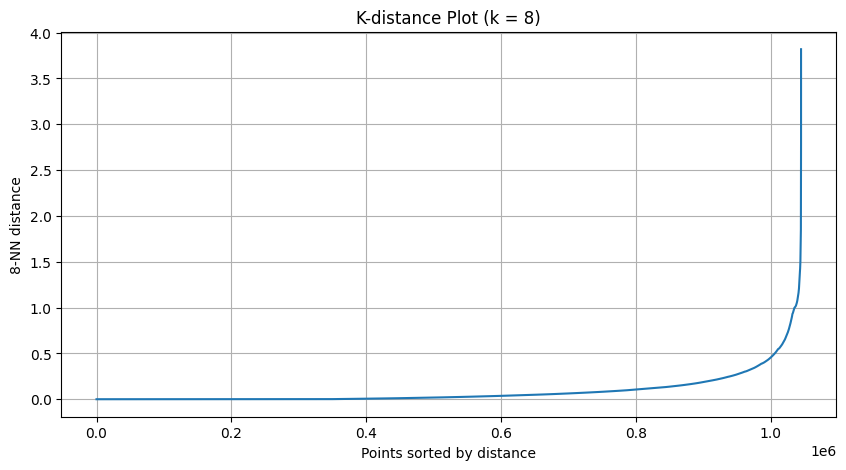

In [3]:
# start with MinPts = 8
min_samples = 8

# set k accordingly 
k = min_samples

# fit NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_input)
distances, indices = neighbors_fit.kneighbors(df_input)

# k-distance = distance to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])

# plot k-distance graph
plt.figure(figsize=(10,5))
plt.plot(k_distances)
plt.title(f'K-distance Plot (k = {k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.grid(True)
plt.show()

The elbow is usually where <ins>concavity changes</ins>. In this case, this point seems to be somewhere between 1.0 and 1.3.

<ins>**Will choose eps = 1.2**</ins>

## DBSCAN Cluster creation

In [4]:
# additional steps to manage dataset size to prevent RAM overuse

# use sample 
df_sample = df_input.sample(250_000, random_state=42)

# convert to float32 for lower RAM footprint
feature_cols = df_sample.columns.tolist()
X = df_sample[feature_cols].astype(np.float32).values

# print shape and memory usage
print("Feature matrix shape:", X.shape)
print("Memory usage (approx):", X.nbytes / 1e6, "MB")

Feature matrix shape: (250000, 10)
Memory usage (approx): 10.0 MB


In [5]:
# train model

# set hyperparameters based on k-distance plot
eps_value = 1.2
min_samples = 8

# use a 
print("\nRunning DBSCAN...")
db = DBSCAN(
    eps=eps_value,
    min_samples=min_samples,
    metric='euclidean',
    algorithm='brute',   # best for high-dimensional big datasets
    n_jobs=-1            # use all CPU cores (very effective on M2)
)

labels = db.fit_predict(X)

print("DBSCAN finished.")



Running DBSCAN...
DBSCAN finished.


In [11]:
# attach labels back to sampled dataframe
df_sample["cluster"] = labels

# save dataframe with labels
df_sample.to_csv(Path.cwd().parent / 'models/df_sample_with_clusters.csv', index=True)

## Semi-supervised Cluster assignment

<ins>DBSCAN</ins> was used to create cluster labels for a *sample* of <ins>250k out of 1 Mill</ins> total entries in the dataset due to the high RAM requirements.

In order to use its results on the whole dataset, a <ins>lightweight supervised classifier (k-NN)</ins> can be used to essentially extend the cluster labels onto the rest of the dataset. 

This method is called DBSCAN+ or <ins>**semi-supervised clustering**</ins>, since unsupervised clustering is used to create the labels, then these labels are used to train a supervised model in order to predict the labels for the rest of the dataset. 

In [2]:
# load data
df_input_whole = pd.read_csv(Path.cwd().parent / 'data/final/dbscan_input.csv', index_col=0)
df_sample_with_clusters = pd.read_csv(Path.cwd().parent / 'models/df_sample_with_clusters.csv', index_col=0)    

In [18]:
# define and review features
feature_cols = df_sample_with_clusters.columns.drop("cluster").tolist()
print(feature_cols)

['interaction_code', 'region_code', 'source_scale_code', 'Battles', 'Explosions/Remote violence', 'Violence against civilians', 'latitude', 'longitude', 'fatalities_log', 'popbest_log']


In [22]:
# create X and y sets for KNN training from the sampled data
X_sample = df_sample_with_clusters[feature_cols].astype(np.float32).values
y_sample = df_sample_with_clusters["cluster"].astype(int).values

# create X set for KNN prediction on whole data
X_full = df_input_whole[feature_cols].astype(np.float32).values

In [23]:
# train k-NN classifier on sampled data
knn = KNeighborsClassifier(
    n_neighbors=20,
    weights='distance',
    n_jobs=-1
)

print("Training k-NN...")
knn.fit(X_sample, y_sample)
print("Training complete.")

Training k-NN...
Training complete.


In [24]:
# predict clusters for full dataset
full_clusters = knn.predict(X_full)
df_input_whole["cluster"] = full_clusters

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [27]:
# save full dataset with predicted clusters
df_input_whole.to_csv(Path.cwd().parent / 'models/df_full_with_clusters.csv', index=True)

<ins>**NOTE**</ins>

When predicting the whole dataset, notice that the 250k from the sample were not removed. Although it may look like it, this is not a case of leakage and was done on purpose for the following reasons:
1. To ensure that k-NN's prediction of those 250k will be identical to the original DBSCAN labels
2. Removing them would damage cluster formation as they act as 'anchor points' for cluster boundaries. i.e. they are actually necessary for the k-NN to make the correct decision in nearby regions
3. Also, this is standard practice for large scale DBSCAN workflows, i.e. where DBSCAN + k-NN is needed

# Cluster insights

In [31]:
# add labels to original clean data

# select only labels and event id from full dataset with clusters
df_clusters = df_input_whole.reset_index()[["event_id_cnty", "cluster"]]
df_clusters.head()

# load original clean data
df_clean = pd.read_csv(Path.cwd().parent / 'data/clean/acled_clean.csv')

# merge clusters with original clean data
df = df_clean.merge(
    df_clusters,
    on="event_id_cnty",
    how="left"
)

df.head()

,event_id_cnty,event_type,sub_event_type,interaction,region,country,latitude,longitude,geo_precision,source_scale,fatalities,population_best,cluster
0,MMR1,Violence against civilians,Attack,State forces-Civilians,Asia,Myanmar,16.0408,98.1232,2,National,0,7592.0,11.0
1,SOM5580,Battles,Armed clash,Political militia-Political militia,Africa,Somalia,2.2524,44.6905,1,National,7,26203.0,17.0
2,BGD7238,Battles,Armed clash,Political militia-Political militia,Asia,Bangladesh,24.4577,89.7080,1,International,0,82027.0,-1.0
3,ETH1319,Battles,Armed clash,State forces-External/Other forces,Africa,Ethiopia,14.5091,39.4437,2,International,10,23950.0,0.0
4,ETH1320,Battles,Armed clash,State forces-External/Other forces,Africa,Ethiopia,14.5219,39.3850,2,International,10,23950.0,0.0


In [33]:
# as all rows with geo_precision < 3 were removed during clustering, check for any missing clusters
df.isnull().sum()

event_id_cnty          0
event_type             0
sub_event_type         0
interaction            0
region                 0
country                0
latitude               0
longitude              0
geo_precision          0
source_scale           0
fatalities             0
population_best        0
cluster            20309
dtype: int64

In [34]:
# drop rows with missing clusters
df.dropna(subset=["cluster"], inplace=True)

## Basic cluster descriptive statistics

In [ ]:
# 

In [29]:
df_clean.head()

,event_id_cnty,event_type,sub_event_type,interaction,region,country,latitude,longitude,geo_precision,source_scale,fatalities,population_best
0,MMR1,Violence against civilians,Attack,State forces-Civilians,Asia,Myanmar,16.0408,98.1232,2,National,0,7592.0
1,SOM5580,Battles,Armed clash,Political militia-Political militia,Africa,Somalia,2.2524,44.6905,1,National,7,26203.0
2,BGD7238,Battles,Armed clash,Political militia-Political militia,Asia,Bangladesh,24.4577,89.7080,1,International,0,82027.0
3,ETH1319,Battles,Armed clash,State forces-External/Other forces,Africa,Ethiopia,14.5091,39.4437,2,International,10,23950.0
4,ETH1320,Battles,Armed clash,State forces-External/Other forces,Africa,Ethiopia,14.5219,39.3850,2,International,10,23950.0


In [ ]:
df = df_input_whole.copy()